In [1]:
##Based on  Jason Brownlee Tutorial : 
#https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
from pandas import DataFrame
from pandas import concat

from math import sqrt
from numpy import concatenate
from numpy import array
from numpy import hstack

from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

#settings for graphics
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(17, 6)})

#  
# Otherwise, you use future information at the time of forecasting 
# which commonly biases forecasting metrics in a positive direction

#Divide Dataset intro train and test sets
def split_data(dataset,split):
    n_train_hours = int(len(df) * split)
    train=df.iloc[:n_train_hours].to_numpy()
    test=df.iloc[n_train_hours:].to_numpy()
    print("Total obs: {}, training obs:{}, test obs:{}".format(len(dataset),n_train_hours,len(dataset)-n_train_hours))
    return train,test

# Standarize data based on train set
def scale(train, test):
    #calculation of scaling statistics has to be conducted on training data 
    #and must then be applied to the test data:
    # fit scaler
    scaler = RobustScaler() # or with minmax feature_range=(-1, 1)
    scaler = scaler.fit(train)
    # transform train
    train_scaled = scaler.transform(train)
    # transform test
    test_scaled = scaler.transform(test)
    print("Train and Test set scaled")
    return scaler, train_scaled, test_scaled

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out-1
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)


#Invert Scaling element
def invert_scale(scaler, X_sample,Y_sample):
    XY_array=np.hstack((X_sample, Y_sample.reshape(Y_sample.shape[0],1)))
    inverted = scaler.inverse_transform(XY_array)
    return inverted[0:, -1]

# MAPE calculation
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Evaluate one or more hourly forecasts against expected values
def evaluate_forecasts(actual, predicted):
    MAE,MSE,RMSE,MAPE = [],[],[],[]
    # calculate an error score for each hour predicted
    for i in range(actual.shape[1]):
        mae= mean_absolute_error(actual[:, i], predicted[:, i])# calculate mae
        MAE.append(mae) # store
        mse = mean_squared_error(actual[:, i], predicted[:, i])# calculate mse
        MSE.append(mse)
        rmse = sqrt(mse)# calculate rmse
        RMSE.append(rmse) # store
        mape=mean_absolute_percentage_error(actual[:, i], predicted[:, i])
        MAPE.append(mape)
    scores=pd.DataFrame(list(zip(MAE,RMSE,MAPE)),columns=['MAE','RMSE','MAPE'])
    scores.index = ['t+'+str(i) for i in range(1,len(scores)+1)]
    scores.loc['mean'] = scores.mean()
    return scores


import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

import os
import pandas as pd
directory = os.getcwd()
os.chdir(os.path.abspath(os.path.join(directory, os.pardir)))# change dir to parent folder

Using TensorFlow backend.


In [2]:
# 0 # LOAD  DATASET:
df=pd.read_excel(os.getcwd()+"\Data Preparation\dataset.xlsx",sep=';',index_col=0,usecols=range(0,9))
df=df[df.columns[list(range(1,8))+[0]]]
os.chdir(directory)
print("NaN tweet rows: ",len(df)-df['X.tweets'].dropna().count())
print("from {} , equivalent to {}% of total data dropped".format(len(df),round(100*(len(df)-df['X.tweets'].dropna().count())/len(df),2)))
df=df.dropna()
df.head()

NaN tweet rows:  786
from 18757 , equivalent to 4.19% of total data dropped


,Volume.BTC,Volume.USD,Gtrends,X.tweets,AdrActCnt,TxTfrValMeanUSD,NVTAdj90,Close
Datetime,,,,,,,,
2017-07-02 00:00:00,495.46,1188396.86,3.511032,488.0,604820.0,6281.414986,32.921171,2386.62
2017-07-02 01:00:00,468.69,1121210.41,3.551389,414.0,604820.0,6281.414986,32.921171,2399.99
2017-07-02 02:00:00,593.55,1417809.15,3.551389,423.0,604820.0,6281.414986,32.921171,2395.00
2017-07-02 03:00:00,410.48,984224.09,3.591746,363.0,604820.0,6281.414986,32.921171,2400.00
2017-07-02 04:00:00,347.06,830156.89,3.511032,393.0,604820.0,6281.414986,32.921171,2402.99


In [3]:
Split = 0.8      # Training Data portion
n_steps_in = 12  # 
n_steps_out = 12  #

# 1 # PREPARE DATA FOR LSTM:
train,test=split_data(df,Split) #Split train and test
scaler, train_scaled, test_scaled=scale(train,test) #Standarize/Scale

# Reframe to supervised learning [samples,time_steps,features]:
X_train,y_train=split_sequences(train_scaled,n_steps_in,n_steps_out)
X_test,y_test=split_sequences(test_scaled,n_steps_in,n_steps_out)
print("Train reframed to X:{} and y:{}".format(X_train.shape,y_train.shape))
print("Test reframed to X:{} and y:{}".format(X_test.shape,y_test.shape))

Total obs: 17958, training obs:14366, test obs:3592
Train and Test set scaled
Train reframed to X:(14344, 12, 7) and y:(14344, 12)
Test reframed to X:(3570, 12, 7) and y:(3570, 12)


In [4]:
# 2 # Build and Train Model (VECTOR OUTPUT)

# define parameters
n_layers,neurons,dropout=3,250,0.2 #Set model param.
verbose, epochs, batch_size = 2, 100, 64 #Set fitting param.
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
# reshape output into [samples, timesteps, features]
y_train_reshaped = y_train.reshape((y_train.shape[0], y_train.shape[1], 1))
y_test_reshaped = y_test.reshape((y_test.shape[0], y_test.shape[1], 1))

# define model Encoder equal to Decoder for multistep forecast:
model = Sequential()
model.add(LSTM(neurons, input_shape=(n_timesteps, n_features)))
model.add(RepeatVector(n_outputs))
model.add(LSTM(neurons, return_sequences=True))
model.add(TimeDistributed(Dense(neurons)))
model.add(TimeDistributed(Dense(1)))
model.compile(loss='mse', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 250)               258000    
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 12, 250)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 12, 250)           501000    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 12, 250)           62750     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 12, 1)             251       
Total params: 822,001
Trainable params: 822,001
Non-trainable params: 0
_________________________________________________________________


In [5]:
# train/fit model
es = EarlyStopping(monitor='val_loss', verbose=1,patience=12,restore_best_weights=True) #early stop if loss starts to increase
mc = ModelCheckpoint('encoder=decoder12_1.h5', monitor='val_loss', verbose=1,save_best_only=True)
history=model.fit(X_train, y_train_reshaped, epochs=epochs, batch_size=batch_size, verbose=verbose,\
          validation_data=(X_test, y_test_reshaped),shuffle=False, callbacks=[es,mc])

Train on 14344 samples, validate on 3570 samples
Epoch 1/100
 - 63s - loss: 0.0971 - val_loss: 0.6218

Epoch 00001: val_loss improved from inf to 0.62182, saving model to encoder=decoder12_1.h5
Epoch 2/100
 - 50s - loss: 0.0944 - val_loss: 0.6146

Epoch 00002: val_loss improved from 0.62182 to 0.61457, saving model to encoder=decoder12_1.h5
Epoch 3/100
 - 50s - loss: 0.0877 - val_loss: 0.4673

Epoch 00003: val_loss improved from 0.61457 to 0.46730, saving model to encoder=decoder12_1.h5
Epoch 4/100
 - 50s - loss: 0.1150 - val_loss: 0.2860

Epoch 00004: val_loss improved from 0.46730 to 0.28604, saving model to encoder=decoder12_1.h5
Epoch 5/100
 - 51s - loss: 0.1224 - val_loss: 0.1792

Epoch 00005: val_loss improved from 0.28604 to 0.17919, saving model to encoder=decoder12_1.h5
Epoch 6/100
 - 46s - loss: 0.0904 - val_loss: 0.1248

Epoch 00006: val_loss improved from 0.17919 to 0.12478, saving model to encoder=decoder12_1.h5
Epoch 7/100
 - 37s - loss: 0.0745 - val_loss: 0.1005

Epoch 0


Epoch 00067: val_loss improved from 0.01550 to 0.01469, saving model to encoder=decoder12_1.h5
Epoch 68/100
 - 43s - loss: 0.0103 - val_loss: 0.0207

Epoch 00068: val_loss did not improve from 0.01469
Epoch 69/100
 - 43s - loss: 0.0099 - val_loss: 0.0090

Epoch 00069: val_loss improved from 0.01469 to 0.00897, saving model to encoder=decoder12_1.h5
Epoch 70/100
 - 39s - loss: 0.0116 - val_loss: 0.0186

Epoch 00070: val_loss did not improve from 0.00897
Epoch 71/100
 - 29s - loss: 0.0113 - val_loss: 0.0171

Epoch 00071: val_loss did not improve from 0.00897
Epoch 72/100
 - 29s - loss: 0.0103 - val_loss: 0.0172

Epoch 00072: val_loss did not improve from 0.00897
Epoch 73/100
 - 37s - loss: 0.0089 - val_loss: 0.0174

Epoch 00073: val_loss did not improve from 0.00897
Epoch 74/100
 - 43s - loss: 0.0074 - val_loss: 0.0133

Epoch 00074: val_loss did not improve from 0.00897
Epoch 75/100
 - 43s - loss: 0.0180 - val_loss: 0.0209

Epoch 00075: val_loss did not improve from 0.00897
Epoch 76/100

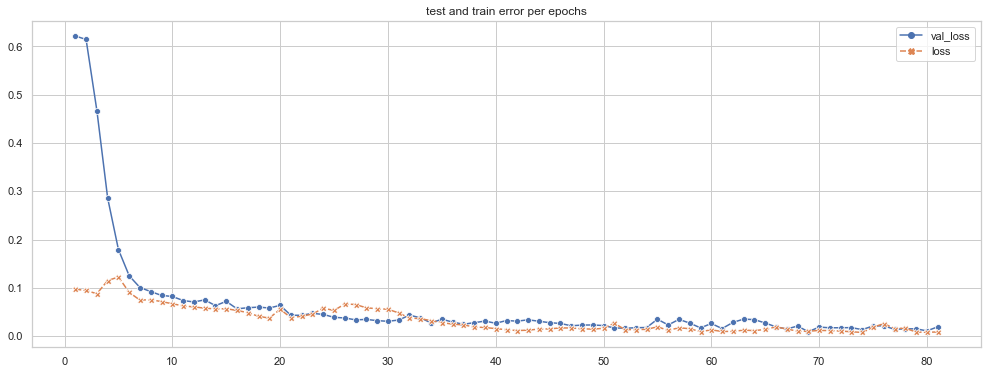

In [6]:
sns.set(rc={'figure.figsize':(17, 6)})
Data=pd.DataFrame(history.history,index=range(1,len(history.history['loss'])+1))
with sns.axes_style("whitegrid"):
    ax=sns.lineplot(data=Data,markers=True).set_title('test and train error per epochs')

In [7]:
Y_predicted=model.predict(X_test)

In [8]:
Y_rescaled=[]
for i in range(len(Y_predicted)):
    Y_rescaled.append(invert_scale(scaler,X_test[i],Y_predicted[i]))
Y_predicted=array(Y_rescaled)

In [9]:
Y_predicted[0:3]

array([[3874.8350006 , 3897.05220374, 3903.78276364, 3913.93106721,
        3915.05137333, 3915.88107279, 3914.29569632, 3910.40690069,
        3904.74405856, 3898.85516135, 3893.76082162, 3889.929599  ],
       [3852.25590993, 3861.34372351, 3870.89162275, 3876.73117167,
        3876.00540272, 3875.18467568, 3872.60236385, 3867.61070846,
        3860.83179719, 3853.87642837, 3847.89780697, 3843.4056162 ],
       [3874.27272905, 3864.67423533, 3877.12894888, 3883.36826888,
        3883.07641605, 3882.32298215, 3880.03352008, 3875.46830379,
        3869.23720851, 3862.82342483, 3857.3041414 , 3853.14866555]])

In [10]:
X_true,y_true=split_sequences(test,n_steps_in,n_steps_out)
y_true[0:3]

array([[3974.94, 3975.1 , 3968.87, 3965.5 , 3983.97, 3998.49, 4005.77,
        3988.08, 3981.26, 3935.7 , 3955.93, 3955.55],
       [3975.1 , 3968.87, 3965.5 , 3983.97, 3998.49, 4005.77, 3988.08,
        3981.26, 3935.7 , 3955.93, 3955.55, 3966.21],
       [3968.87, 3965.5 , 3983.97, 3998.49, 4005.77, 3988.08, 3981.26,
        3935.7 , 3955.93, 3955.55, 3966.21, 3956.  ]])

In [11]:
evaluate_forecasts(y_true,Y_predicted)

,MAE,RMSE,MAPE
t+1,252.676983,347.308289,3.055663
t+2,247.395844,355.188330,2.922361
t+3,257.860955,371.188881,3.040559
t+4,260.205770,375.996158,3.074920
t+5,265.222927,383.065360,3.145788
t+6,270.388539,390.812687,3.206638
t+7,276.132674,398.822695,3.275006
t+8,282.094794,407.004601,3.350097
t+9,288.106312,415.232511,3.429579
t+10,294.382575,423.271947,3.514480


Text(0.5, 1.0, 'test vs predicted[?]')

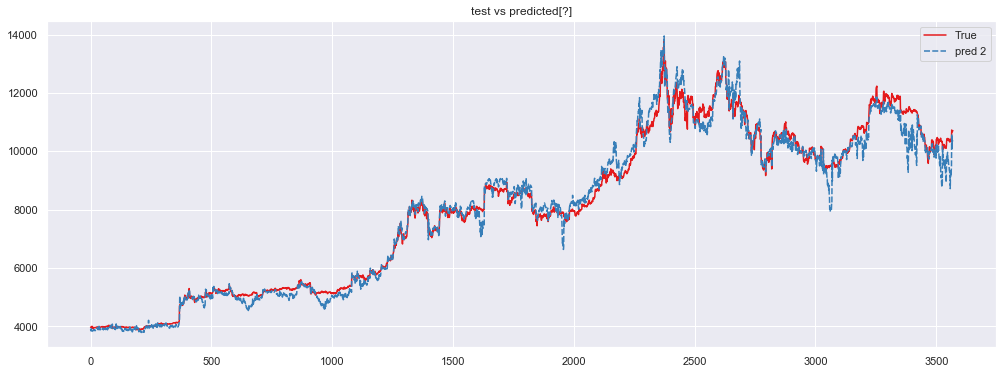

In [18]:
sns.set(rc={'figure.figsize':(17, 6)})
cols=['True']+['pred '+str(i) for i in range(1,n_steps_out+1)]
Data=pd.DataFrame(np.hstack((y_true[:,0].reshape(y_true[:,0].shape[0],1),Y_predicted)),columns=cols)
sns.lineplot(data=Data[['True','pred 2']],palette='Set1').set_title('test vs predicted[?]')

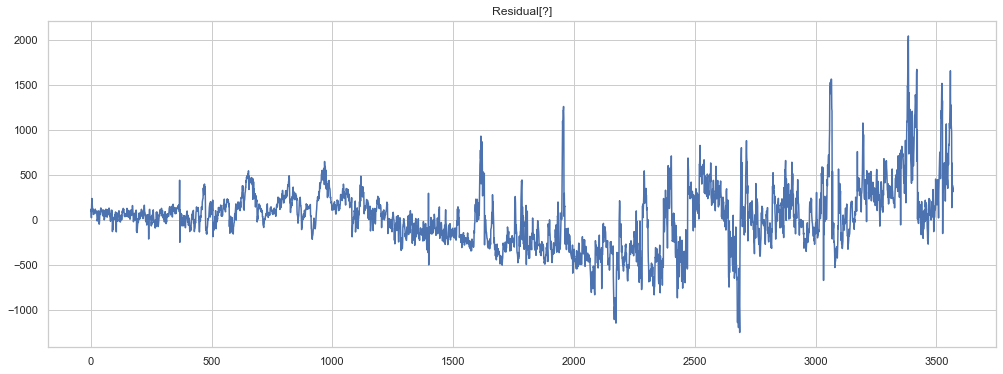

In [19]:
residual = Data['True']-Data['pred 1']
with sns.axes_style("whitegrid"):
    ax=sns.lineplot(data=residual).set_title('Residual[?]')

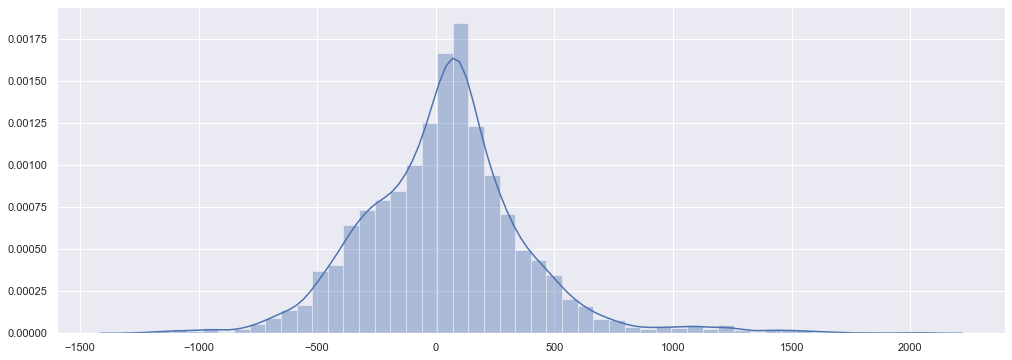

In [20]:
sns.distplot(residual);

In [13]:
##Taken from Jason Brownlee Tutorial : 
#https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

